In [2]:
from sentence_transformers import SentenceTransformer

c:\Users\Rupesh Kumar singh\OneDrive\Desktop\Work\IS\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model = SentenceTransformer('clip-ViT-B-32')

In [2]:
from glob import glob
import os
from PIL import Image

def generate_clip_embeddings(images_path, model):

    image_paths = glob(os.path.join(images_path, '**/*.png'), recursive=True)
    
    embeddings = []
    for img_path in image_paths:
        image = Image.open(img_path)
        embedding = model.encode(image)
        embeddings.append(embedding)
    
    return embeddings, image_paths

In [8]:
IMAGES_PATH = 'images'

embeddings, image_paths = generate_clip_embeddings(IMAGES_PATH, model)

In [10]:
import faiss
import numpy as np

def create_faiss_index(embeddings, image_paths, output_path):

    dimension = len(embeddings[0])
    index = faiss.IndexFlatIP(dimension)
    index = faiss.IndexIDMap(index)
    
    vectors = np.array(embeddings).astype(np.float32)

    # Add vectors to the index with IDs
    index.add_with_ids(vectors, np.array(range(len(embeddings))))
    
    # Save the index
    faiss.write_index(index, output_path)
    print(f"Index created and saved to {output_path}")
    
    # Save image paths
    with open(output_path + '.paths', 'w') as f:
        for img_path in image_paths:
            f.write(img_path + '\n')
    
    return index

In [12]:
OUTPUT_INDEX_PATH = "vector.index"
index = create_faiss_index(embeddings, image_paths, OUTPUT_INDEX_PATH)

Index created and saved to vector.index


In [13]:
def load_faiss_index(index_path):
    index = faiss.read_index(index_path)
    with open(index_path + '.paths', 'r') as f:
        image_paths = [line.strip() for line in f]
    print(f"Index loaded from {index_path}")
    return index, image_paths

In [14]:
index, image_paths = load_faiss_index(OUTPUT_INDEX_PATH)

Index loaded from vector.index


In [15]:
def retrieve_similar_images(query, model, index, image_paths, top_k=3):
    
    # query preprocess:
    if query.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
        query = Image.open(query)

    query_features = model.encode(query)
    query_features = query_features.astype(np.float32).reshape(1, -1)

    distances, indices = index.search(query_features, top_k)

    retrieved_images = [image_paths[int(idx)] for idx in indices[0]]

    return query, retrieved_images

In [17]:
import matplotlib.pyplot as plt

def visualize_results(query, retrieved_images):
    plt.figure(figsize=(12, 5))

    # If image query
    if isinstance(query, Image.Image):
        plt.subplot(1, len(retrieved_images) + 1, 1)
        plt.imshow(query)
        plt.title("Query Image")
        plt.axis('off')
        start_idx = 2

    # If text query
    else:
        plt.subplot(1, len(retrieved_images) + 1, 1)
        plt.text(0.5, 0.5, f"Query:\n\n '{query}'", fontsize=16, ha='center', va='center')
        plt.axis('off')
        start_idx = 2

    # Display images
    for i, img_path in enumerate(retrieved_images):

        plt.subplot(1, len(retrieved_images) + 1, i + start_idx)
        plt.imshow(Image.open(img_path))
        plt.title(f"Match {i + 1}")
        plt.axis('off')

    plt.show()

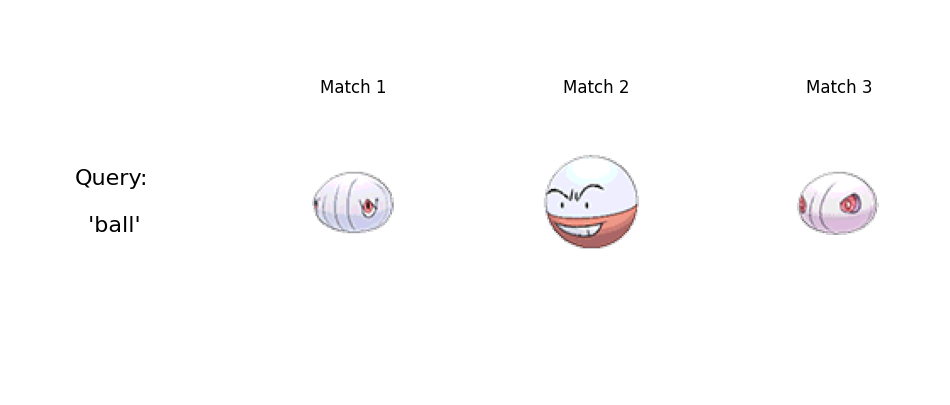

In [ ]:
query = 'ball'
query, retrieved_images = retrieve_similar_images(query, model, index, image_paths, top_k=3)
visualize_results(query, retrieved_images)

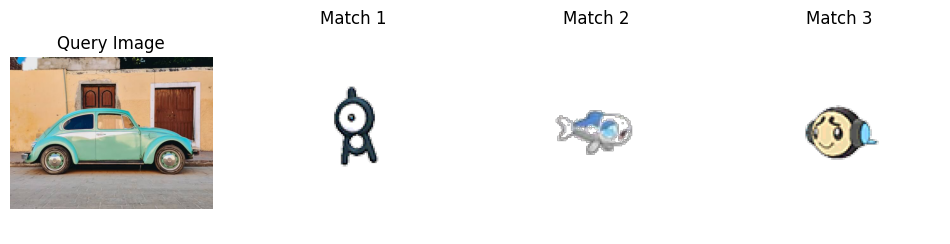

In [19]:
query = 'car.jpg'
query, retrieved_images = retrieve_similar_images(query, model, index, image_paths, top_k=3)
visualize_results(query, retrieved_images)

In [3]:
query = Image.open('car.jpg')

In [5]:
type(query)

PIL.JpegImagePlugin.JpegImageFile